In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
     

def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  v = np.zeros((n+1,len(y0)))
  y[0] = y0
  v[0] = f(t[0],y[0],gamma)

  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
    v[i+1] = f(t[i+1],y[i+1],gamma)
  return y,t,v

In [2]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.0005 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))
     

k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
np.random.seed(0)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)
A_vals = A(K,L)

def modulo_grid(x, y):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod,y_mod

def streamfunction(t,pos):
  x_mod,y_mod = modulo_grid(*pos)
  psi = np.sum(A_vals * np.cos(K*x_mod + L*y_mod - omega_vals*t + phi))
  return psi

def f(t,pos,gamma):
  #Uncomment to freeze the velocity field at t=snapshot:
  #t = snapshot
  x_mod,y_mod = modulo_grid(*pos)
  dpsi_dx = -np.sum(A_vals*K*np.sin(K*x_mod + L*y_mod - omega_vals*t + phi))
  dpsi_dy = -np.sum(A_vals * L * np.sin(K*x_mod + L*y_mod - omega_vals*t + phi))
  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  return np.array([u,v])

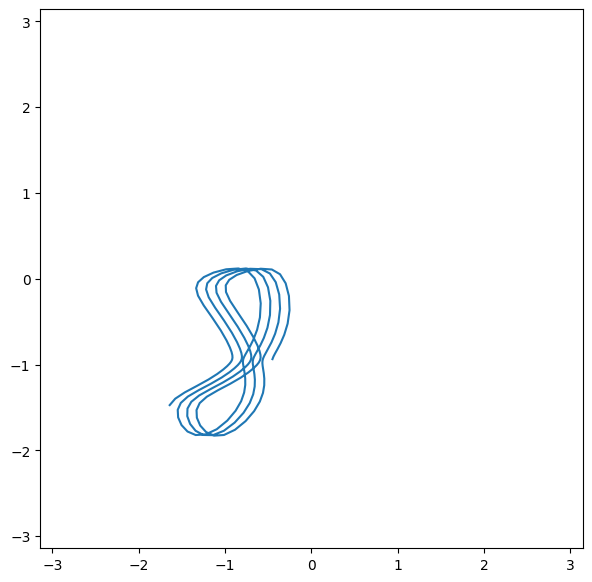

In [3]:
#Generate an ensemble of trajectories:

num_points = 100
np.random.seed(1)
x_coords = np.random.uniform(-np.pi, np.pi, num_points)
np.random.seed(2)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)
initial_conditions = np.column_stack((x_coords, y_coords))

time_span = 1000 #number of days
n = 200 #number of time steps
dt = time_span / n #length of timestep

#Select the value of gamma
gamma = 0

#Store the corresponding trajectories, and velocities along them.
solutions = []
vels = []
for y0 in initial_conditions:
  y,t,v = rk4(f,y0,dt,n,gamma)
  solutions.append(y)
  vels.append(v)


     

#Visualise a single trajectory
i = 86
sol = solutions[i]
vel = vels[i]

fig,ax = plt.subplots(figsize=(7,7))

ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.plot(sol[:,0],sol[:,1])

Text(0.5, 1.0, 'Velocity Time Series of X component')

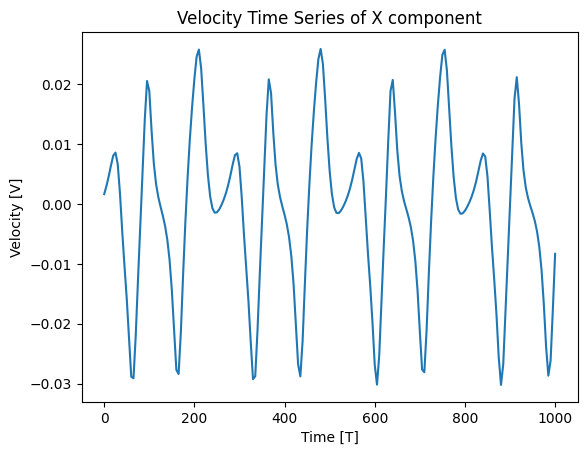

In [9]:
x_vel_array = vels[86][:,0]
plt.plot(t, x_vel_array)
plt.xlabel('Time [T]')
plt.ylabel('Velocity [V]')
plt.title('Velocity Time Series of X component')

Text(0.5, 1.0, 'Velocity Time Series of Y component')

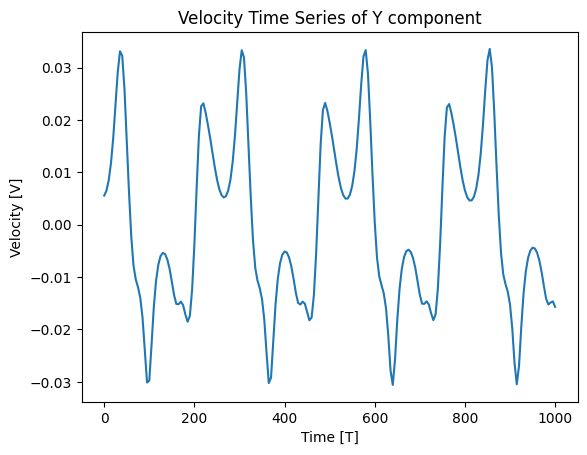

In [10]:
y_vel_array = vels[86][:,1]
plt.plot(t, y_vel_array)
plt.xlabel('Time [T]')
plt.ylabel('Velocity [V]')
plt.title('Velocity Time Series of Y component')

(0.0, 650.0)

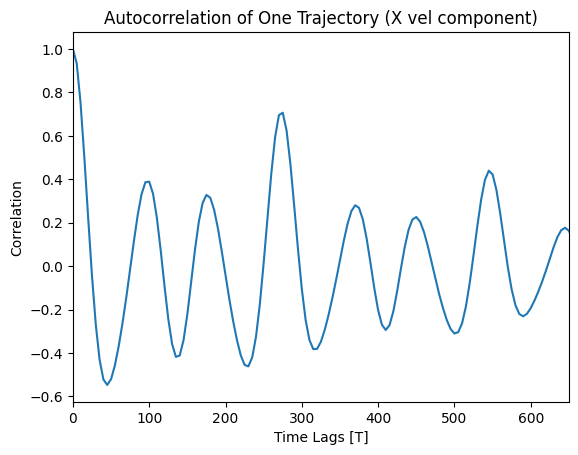

In [11]:
mean = np.mean(x_vel_array)

var = np.var(x_vel_array)

ndata = x_vel_array - mean

acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:]
acorr = acorr / var / len(ndata)

plt.plot(t, acorr)
plt.xlabel('Time Lags [T]')
plt.ylabel('Correlation')
plt.title('Autocorrelation of One Trajectory (X vel component)')
plt.xlim(0, 650)